In [4]:
import pickle

from pyboost import controllers as pb
from pyspark import SparkContext


sc = SparkContext(master="local[3]")
# sc = SparkContext(master=master_url, pyFiles=["dist/pyboost-0.1-py2.7.egg"])
sc.setCheckpointDir('checkpoint/')

In [1]:
import pickle

X_train, X_test, y_train, y_test = pickle.load(open("../experiments/higgs/data/higgs-data-1p.pickle"))
# X_train, X_test, y_train, y_test = pickle.load(open("../../higgs-data-1p.pickle"))
y_train = [y + y - 1 for y in y_train]
y_test = [y + y - 1 for y in y_test]

In [2]:
import numpy as np
from numpy.random import choice

train_sample = choice(len(y_train), size=int(len(y_train) * 0.01), replace=False)
test_sample = choice(len(y_test), size=int(len(y_test) * 0.01), replace=False)

X_train = np.array(X_train)[train_sample]
y_train = np.array(y_train)[train_sample]
X_test = np.array(X_test)[test_sample]
y_test = np.array(y_test)[test_sample]

len(y_train), len(y_test)

(1000, 100)

In [5]:
X = sc.parallelize(X_train)
y = sc.parallelize(y_train)

In [24]:
num_round = 200

In [25]:
adaboost = pb.run_adtree_adaboost(sc, y, X, T=num_round, quiet=True)

In [26]:
adaboost_r = pb.run_adtree_adaboost(sc, y, X, T=num_round, repartition=True, quiet=True)

In [27]:
adaboost_f = pb.run_adtree_full_adaboost(sc, y, X, T=num_round, quiet=True)

In [ ]:
logitboost = pb.run_adtree_logitboost(sc, y, X, T=num_round, quiet=False)

In [28]:
import pickle

pickle.dump(adaboost, open("adaboost.pkl", 'w'))
pickle.dump(adaboost_r, open("adaboost_r.pkl", 'w'))
pickle.dump(adaboost_f, open("adaboost_f.pkl", 'w'))
# pickle.dump(logitboost, open("logitboost.pkl", 'w'))

In [2]:
adaboost = pickle.load(open("result/adaboost.pkl"))
logitboost = pickle.load(open("result/logitboost.pkl"))

# Performance

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from pyboost.adtree import run_tree
from pyboost.utils import safe_comp

def test_error(nodes, y, X, max_index=None):    
    error = 0
    margin = 0.0
    for tX, ty in zip(X, y):
        _m = run_tree(0, nodes, tX, max_index=max_index)
        predict = safe_comp(_m)
        if safe_comp(predict, ty):
            error += 1
        margin += _m * ty
    return 1.0 - float(error) / len(y), margin / len(y)


def test_all(nodes):
    train_accuracy, train_margin = test_error(nodes, y_train, X_train)
    test_accuracy, test_margin = test_error(nodes, y_test, X_test)
    print "Train accuracy:", train_accuracy, '\t',
    print "Train margin:", train_margin
    print "Test accuracy:", test_accuracy, '\t',
    print "Test margin:", test_margin


def test_margin(nodes):
    for max_index in range(len(nodes) + 1):
        accuracy, margin = test_error(nodes, y_train, X_train, max_index=max_index)
        print max_index, accuracy, margin


def test_improve(nodes):
    accuracy_train = []
    accuracy_test = []
    auc_train = []
    auc_test = []

    raw_y_train_pred = [0.0] * len(y_train)
    y_train_pred = [None] * len(y_train)
    raw_y_test_pred = [0.0] * len(y_test)
    y_test_pred = [None] * len(y_test)
    for i in range(len(nodes)):
        print '.',
        # Update predicts
        for idx, x in enumerate(X_train):
            raw_y_train_pred[idx] += nodes[i].predict(x, pre_check=False)
            y_train_pred[idx] = safe_comp(raw_y_train_pred[idx])
        for idx, x in enumerate(X_test):
            raw_y_test_pred[idx] += nodes[i].predict(x, pre_check=False)
            y_test_pred[idx] = safe_comp(raw_y_test_pred[idx])
        # Update train scores
        accuracy_train.append(accuracy_score(y_train, y_train_pred))
        auc_train.append(roc_auc_score(y_train, y_train_pred))
        # Update test scores
        accuracy_test.append(accuracy_score(y_test, y_test_pred))
        auc_test.append(roc_auc_score(y_test, y_test_pred))
    return (accuracy_train, auc_train), (auc_train, auc_test)

## Performance of AdaBoost

In [29]:
(accuracy_train, auc_train), (accuracy_test, auc_test) = test_improve(adaboost)
(accuracy_train_r, auc_train_r), (accuracy_test_r, auc_test_r) = test_improve(adaboost_r)
(accuracy_train_f, auc_train_f), (accuracy_test_f, auc_test_f) = test_improve(adaboost_f)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [37]:
pickle.dump(((accuracy_train, auc_train), (accuracy_test, auc_test)), open("result/adaboost_trend.pkl", 'w'))ru

In [2]:
import pickle

(accuracy_train, auc_train), (accuracy_test, auc_test) = pickle.load(open("result/adaboost_trend.pkl"))

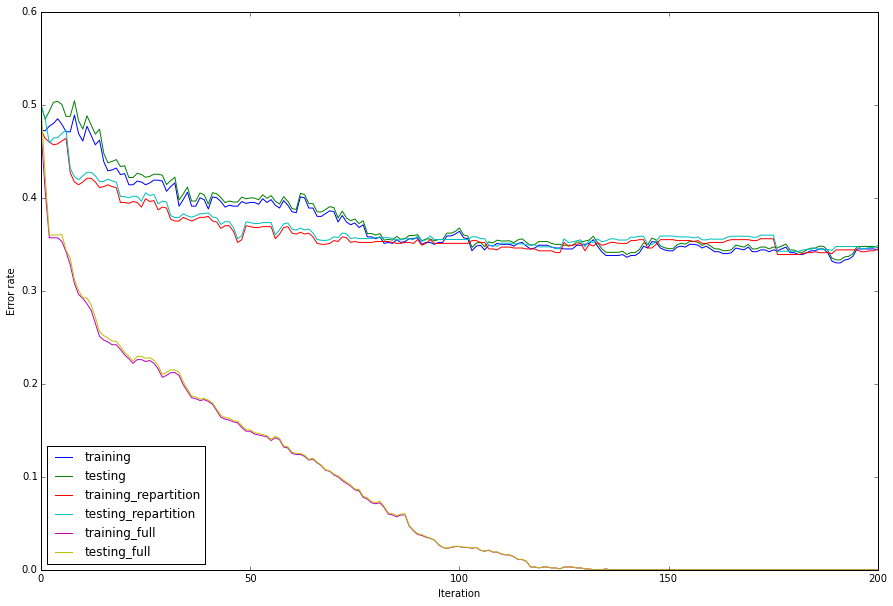

In [31]:
%matplotlib inline
from matplotlib import pyplot as plt

f = lambda ts: map(lambda t: 1.0 - t, ts)
plt.figure(figsize=(15, 10))
plt.plot(f(accuracy_train), label="training")
plt.plot(f(accuracy_test), label="testing")
plt.plot(f(accuracy_train_r), label="training_repartition")
plt.plot(f(accuracy_test_r), label="testing_repartition")
plt.plot(f(accuracy_train_f), label="training_full")
plt.plot(f(accuracy_test_f), label="testing_full")
plt.xlabel("Iteration")
plt.ylabel("Error rate")
plt.legend(loc="lower left")

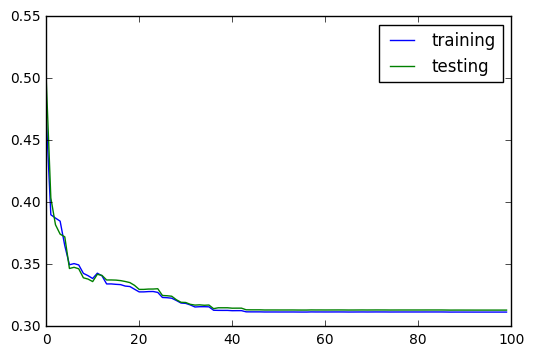

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

f = lambda ts: map(lambda t: 1.0 - t, ts)
plt.plot(f(accuracy_train[:100]), label="training")
plt.plot(f(accuracy_test[:100]), label="testing")
plt.legend()

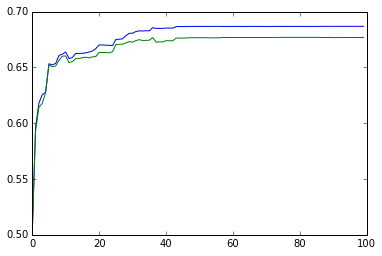

In [41]:
plt.plot(auc_train[:100])
plt.plot(auc_test[:100])

In [58]:
print "Test accuracy:", "%.2f" % (accuracy_test[-1] * 100) + '%'

Test accuracy: 68.67%


In [32]:
def vis_score(nodes, max_index=None):
    scores = []
    for x, y in zip(X_train, y_train):
        scores.append(y * run_tree(0, nodes, x, max_index=max_index))
    return sorted(scores)

In [34]:
# Collect margins

'''
T = num_round

scores = []
scores.append(vis_score(adaboost_r, max_index=0))
for max_index in range(1, T):
    scores.append(vis_score(adaboost_r, max_index=max_index))

scores_f = []
scores_f.append(vis_score(adaboost_f, max_index=0))
for max_index in range(1, T):
    scores_f.append(vis_score(adaboost_f, max_index=max_index))
'''

In [68]:
%matplotlib inline
from matplotlib import pyplot as plt

def draw_visscore(scores, step=1, lim=None):
    T = len(scores)
    nhist = T / step + 1
    plt.figure(1, figsize=(8, nhist * 5))

    sharex = plt.subplot(nhist, 1, 1)
    plt.title("Iteration 0")
    plt.hist(scores[0], 100)
    plt.axvline(0.0, color='r', linestyle='dashed', linewidth=2)

    mins, maxs = min(scores[0]), max(scores[0])
    for idx, max_index in enumerate(range(0, T, step)):
        if max_index == 0:
            continue
        mins = min(mins, min(scores[max_index]))
        maxs = max(maxs, max(scores[max_index]))
        plt.subplot(nhist, 1, idx + 1, sharex=sharex)
        plt.title("Iteration " + str(max_index))
        plt.hist(scores[max_index], 100)
        plt.axvline(0.0, color='r', linestyle='dashed', linewidth=2)

    if lim is None:
        lim = max(-mins, maxs)
    plt.xlim(-lim, lim)

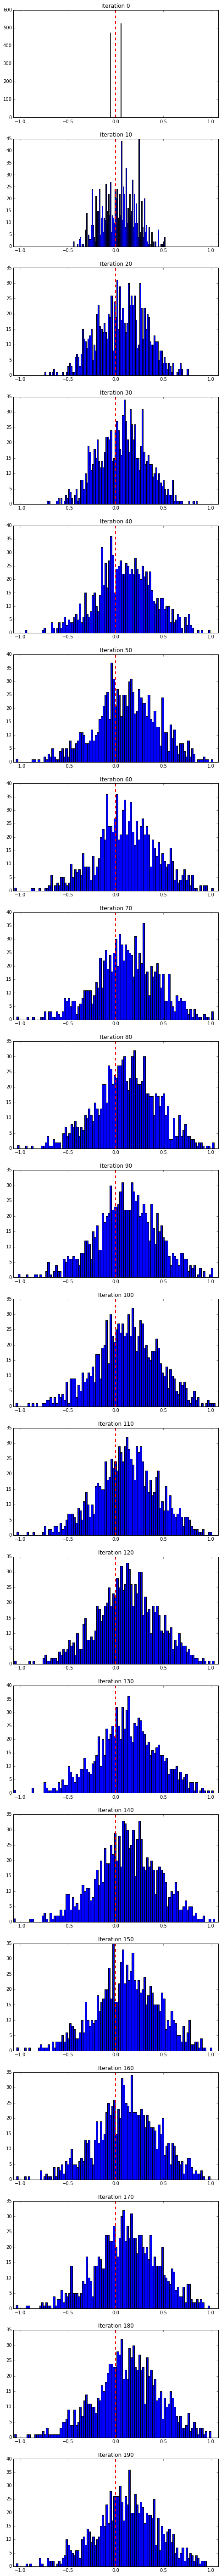

In [69]:
draw_visscore(scores, step=10)

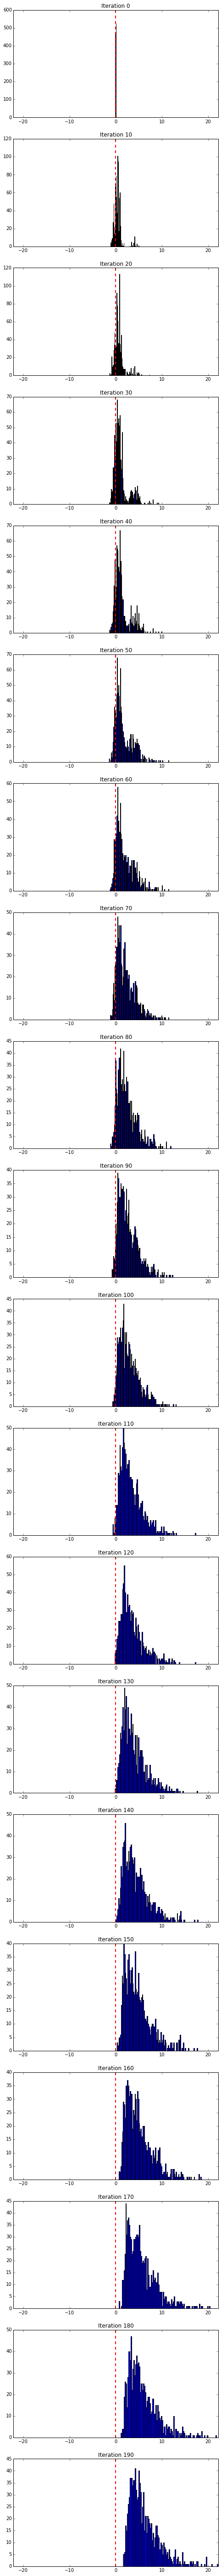

In [70]:
draw_visscore(scores_f, step=10)

# Performance of LogitBoost

In [ ]:
(accuracy_train, auc_train), (accuracy_test, auc_test) = test_improve(logitboost)

In [ ]:
# (accuracy_train, auc_train), (accuracy_test, auc_test) = pickle.load(open("result/logitboost_trend.pkl"))

In [ ]:
import pickle
pickle.dump(((accuracy_train, auc_train), (accuracy_test, auc_test)), open("result/logitboost_trend.pkl", 'w'))

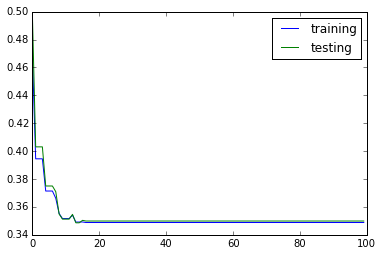

In [44]:
%matplotlib inline
from matplotlib import pyplot as plt

f = lambda ts: map(lambda t: 1.0 - t, ts)
plt.plot(f(accuracy_train[:100]), label="training")
plt.plot(f(accuracy_test[:100]), label="testing")
plt.legend()

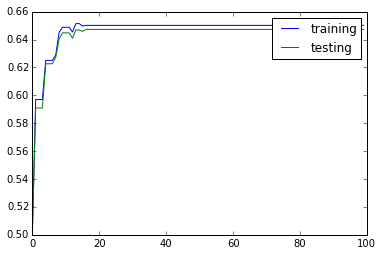

In [45]:
plt.plot(auc_train[:100], label="training")
plt.plot(auc_test[:100], label="testing")
plt.legend()

In [56]:
print "Test accuracy:", "%.2f" % (accuracy_test[-1] * 100) + '%'

Test accuracy: 65.01%
